# The birth of the strong components, draft 1

In this draft, we compute the numerical values of Airy integrals and generalised Airy functions.

## Preliminaries

In [339]:
import sympy as sp
import scipy.integrate as integrate
import numpy as np
import math

We almost don't need `sympy`, but here we use `scipy.integrate` for numerical integration.
I didn't look at which procedure is used, but after some experiments it turns out that we can
easily reach a precision of $10^{-17}$. So to be consistent, this function outputs its "predicted" error, and we can also make sure of the error by extending to integration limits and comparing.
Note that the standard interface also provides infinite limits of integration, but then some technical difficulties appear, so we prefer to avoid this functionality.

First of all, the integration function resorts to some old FORTRAN built-ins, and is not very friendly with complex numbers. As unfortunate as it might be, it is still relatively easy to extend a real-valued integral to a complex-valued (with a complex argument) by linearity of integration. We implement therefore a complex analog in `complex_quad`.

In [340]:
def complex_quad(fun, left, right):
    """
    Complex integration routine.
    Assume that `left` and `right` are complex numbers,
    and we assume a linear trajectory `s = alpha left + (1 - alpha) right`.
    `fun` is a complex-argument function which returns a complex value.
    Invokes `scipy.integrate.quad` with real-valued integration as a subroutine.
    
    N.B. Only finite limits are supported.
    """
    fun_re = lambda z: fun(z).real
    fun_im = lambda z: fun(z).imag
    int_re = integrate.quad(
        lambda t: fun_re(
            t * (right - left) + left
        ),
        0, 1
    )
    int_im = integrate.quad(
        lambda t: fun_im(
            t * (right - left) + left
        ),
        0, 1
    )
    int_cmplx = complex(int_re[0], int_im[0])
    result = int_cmplx * (right - left)
    abserr = abs(complex(int_re[1], int_im[1]) * (right - left))
    return (result, abserr)

#### Three paths of integration

Recall the definition of the generalised Airy function:
$$
    \mathrm{Ai}(r; x)
    =
    (-1)^r \dfrac{1}{2 \pi i}
    \int_{\mathcal C}
    t^r e^{-xt + t^3/3}
    dt,
$$
where the contour $ \mathcal C $ is described in the paper.

In order to construct the generalised Airy function, we need to join three segments.
I was too lazy to avoid copy-pasting, so this cell is a bit dangerous, but it has been verified
many times, so there should be no mistake in the code. Modification is dangerous, still.

In [341]:
def I1(r, x, rlimit = 40):
    """
    For simplicity, we take the integration angle pi/4.
    Later we can update to pi/3 have better convergence.
    """
    return complex_quad(
        lambda t: t**r * np.exp(
            -x * t + t**3/3
        ),
        rlimit * (1 - 1j), 1 - 1j
    )

def I2(r, x, rlimit = 40):
    return complex_quad(
        lambda t: t**r * np.exp(
            -x * t + t**3/3
        ),
        1 - 1j, 1 + 1j
    )

def I3(r, x, rlimit = 40):
    return complex_quad(
        lambda t: t**r * np.exp(
            -x * t + t**3/3
        ),
        1 + 1j, rlimit * (1 + 1j)
    )

In [342]:
def AiryAi(r, x, rlimit = 40):
    """
    Generalised Airy function. The third parameter `rlimit` (optional) stands for the limits of integration.
    Returns a tuple whose first element is the value, and the second is the absolute error of integration.
    """
    i1 = I1(r, x, rlimit)
    i2 = I2(r, x, rlimit)
    i3 = I3(r, x, rlimit)
    integral_result = i1[0] + i2[0] + i3[0]
    abserr = i1[1] + i2[1] + i3[1]
    return (
        (-1)**r / (2 * math.pi * 1j) * integral_result
        ,
        abserr
    )

*Testing the numerical values, compare with Maple and NIST handbook (where possible)*

In [343]:
AiryAi(0, 0)[0]

(0.355028053887817-3.975693351829396e-17j)

In [344]:
AiryAi(0, 1)[0]

(0.1352924163128814-6.736591512822032e-17j)

In [345]:
AiryAi(1, 0)[0]

(-0.2588194037928065-2.208718528794109e-16j)

In [346]:
AiryAi(1, 1)[0]

(-0.15914744129679312+5.4389693771554935e-17j)

The precision is indeed very good

In [347]:
AiryAi(-1, 0)[0]

(-0.33333333333333326+1.159577227616907e-16j)

The above value is similar to the definite integral presented in NIST handbook
$$
    \int_0^\infty \mathrm{Ai}(t) dt = \dfrac{1}{3},
    \quad
    \int_{-\infty}^0 \mathrm{Ai}(t) dt = \dfrac{2}{3}.
$$
In this case, the definite integral corresponding to $ \mathrm{Ai}(-1, x) $ should be taken
from $ -\infty $ to $ x $, and the constant of integration is different, however, it still preserves the rational pattern.

We can conclude (empirically, and maybe prove later) that
$$
    \mathrm{Ai}(-1, x) = \int_{-\infty}^x \mathrm{Ai}(t) dt - 1
    = - \int_{x}^{\infty} \mathrm{Ai}(t) dt \, .
$$

# Testing DAGs and elementary digraphs

First, let us try to reproduce the numerical constants for the center of the critical window

### DAGs, the center of the critical window

Testing the value $ \gamma_1 $

In [354]:
complex_quad(
    lambda t:
    1 / AiryAi(0, -2**(1/3) * t)[0],
    -20j, 20j
)[0] * 2**(-1/3) / (2 * np.pi * 1j)

(0.4887367061531062+7.282354873313424e-17j)

It works!

Let us find out the precision by comparing various integration limits

In [134]:
complex_quad(
    lambda t:
    1 / AiryAi(0, -2**(1/3) * t)[0],
    -40j, 40j
)[0] * 2**(-1/3) / (2 * np.pi * 1j)

(0.48873670615310566+2.3777643574449383e-16j)

In [135]:
0.4887367061531062 - 0.48873670615310566

5.551115123125783e-16

If we change both limits, in the definition of the Airy function, and in the external integral, we might get a more realistic error value.

In [136]:
complex_quad(
    lambda t:
    1 / AiryAi(0, -2**(1/3) * t, rlimit = 60)[0],
    -40j, 40j
)[0] * 2**(-1/3) / (2 * np.pi * 1j)

(0.48873670615299647-3.177366937755987e-16j)

In [137]:
0.4887367061531062 - 0.48873670615299647

1.0974554598419672e-13

$$
    \gamma_{DAG} = 0.488736706153 \ldots
$$

Just try to obtain more digits to identify the number, we increase the integration interval

In [280]:
complex_quad(
    lambda t:
    1 / AiryAi(0, -2**(1/3) * t, rlimit = 80)[0],
    -80j, 80j
)[0] * 2**(-1/3) / (2 * np.pi * 1j)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:17: IntegrationWarning: The integral is probably divergent, or slowly convergent.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:23: IntegrationWarning: The integral is probably divergent, or slowly convergent.


(0.48873670615299913-2.1171654776896658e-16j)

I have tried to identify these numbers among several "inverse numeric calculators", but with no more chance than the first few digits. So probably, there is no simple expression in terms of Gamma functions and rational powers of 2 and 3.

### Elementary digraphs, the center of the critical window

In [281]:
complex_quad(
    lambda t:
    1 / AiryAi(1, -2**(1/3) * t, rlimit = 80)[0],
    -80j, 80j
)[0] * (-2**(-2/3)) / (2 * np.pi * 1j)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:23: IntegrationWarning: The integral is probably divergent, or slowly convergent.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:17: IntegrationWarning: The integral is probably divergent, or slowly convergent.


(0.6996878665105769-5.375168365391257e-15j)

*Precision test*

In [143]:
complex_quad(
    lambda t:
    1 / AiryAi(1, -2**(1/3) * t, rlimit=60)[0],
    -40j, 40j
)[0] * (-2**(-2/3)) / (2 * np.pi * 1j)

(0.6996878665105761-1.5813735154906407e-16j)

In [142]:
(
    complex_quad(
        lambda t:
        1 / AiryAi(1, -2**(1/3) * t)[0],
        -20j, 20j
    )[0] * (-2**(-2/3)) / (2 * np.pi * 1j)
    -
    complex_quad(
        lambda t:
        1 / AiryAi(1, -2**(1/3) * t, rlimit=60)[0],
        -40j, 40j
    )[0] * (-2**(-2/3)) / (2 * np.pi * 1j)
)

(1.3322676295501878e-15-7.852316407907847e-16j)

$$
    \gamma_{elem} = 0.69968786651057 \ldots
$$

### One bicyclic component

In [145]:
(
    1/2                  # compensation factor
    * 2**(-2/3 - 1)      # coeff from varphi_{r,0}
    / (2 * np.pi * 1j)   # from Cauchy integral
    *
    complex_quad(
        lambda t:
        AiryAi(-2, -2**(1/3) * t)[0]
        /
        (AiryAi(1, -2**(1/3) * t)[0])**2,
        -20j, 20j
    )[0]
)

(0.12500000000001252-5.987478181050781e-16j)

In [146]:
(
    1/2                  # compensation factor
    * 2**(-2/3 - 1)      # coeff from varphi_{r,0}
    / (2 * np.pi * 1j)   # from Cauchy integral
    *
    complex_quad(
        lambda t:
        AiryAi(-2, -2**(1/3) * t, rlimit=60)[0]
        /
        (AiryAi(1, -2**(1/3) * t, rlimit = 60)[0])**2,
        -40j, 40j
    )[0]
)

(0.12499999999999954-8.39857510402819e-17j)

$$
    \gamma_{bicyclic} = 1/8
$$

I was totally surprised when I saw this rational number and we have spent several days trying to prove that it indeed takes this value. We discovered that all the (double) poles have, incidentally, zero residues.

Just to be sure, let us check that the sum of probabilities that a digraph is elementary or contains one bicyclic component, is less than one.

In [150]:
0.69968786651057 + 0.125

0.82468786651057

## Theoretical plots for bicyclic digraphs

Make sure it does not take too long (careful if you are going to reproduce it on your own machine).
However, nothing really scary is hapenning here. All the external integrals are taken within a few seconds.

In [559]:
%%time
(
    1
    / (2 * np.pi * 1j)   # from Cauchy integral
    *
    complex_quad(
        lambda t:
        AiryAi(-2, -t)[0]
        /
        (AiryAi(1, -t)[0])**2,
        -20j, 20j
    )[0]
)

CPU times: user 3.81 s, sys: 19.7 ms, total: 3.83 s
Wall time: 3.85 s


(1.000000000000043-3.802736341230832e-15j)

In [721]:
%%time
(
    1
    / (2 * np.pi * 1j)   # from Cauchy integral
    *
    complex_quad(
        lambda t:
        AiryAi(-1, -t)[0]
        /
        (AiryAi(1, -t)[0])**2,
        -20j, 20j
    )[0]
)

CPU times: user 3.41 s, sys: 21.1 ms, total: 3.43 s
Wall time: 3.5 s


(-1.4372766407037851+4.730722269448941e-15j)

# One bicyclic component

In [561]:
mu_values = np.linspace(-6, 4, 100)

In [562]:
%%time
p_values = [
    (
        1/2                  # compensation factor
        * 2**(-2/3 - 1)      # coeff from varphi_{r,0}
        / (2 * np.pi * 1j)   # from Cauchy integral
        *
        complex_quad(
            lambda t:
            AiryAi(-2, -2**(1/3) * t)[0]
            /
            (AiryAi(1, -2**(1/3) * t)[0])**2
            * np.exp(- mu * t - mu**3 / 6)
            ,
            -20j, 20j
        )[0]
    )    
    for mu in mu_values
]

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:17: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:23: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.


CPU times: user 8min 4s, sys: 3.84 s, total: 8min 8s
Wall time: 8min 17s


In [458]:
import matplotlib.pyplot as plt

In [638]:
plt.rcParams.update({'font.size': 13})

We truncate the plot for $ \mu < -5 $ due to numerical problems.

/usr/local/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


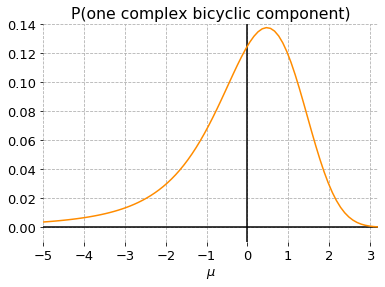

In [644]:
plt.box(on=False)
plt.xlim(-5, 3.2)
plt.ylim(-0.01, 0.14)
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.grid(True, linestyle='--')
plt.xlabel(r"$\mu$")
plt.xticks(np.linspace(-5, 3, 9))
plt.plot(
    mu_values,
    p_values,
    color='darkorange')
plt.title('P(one complex bicyclic component)')
#plt.legend(loc='best')
plt.savefig("proba_bicyclic_MDnp.pdf")

# Elementary digraphs

In [631]:
%%time
mu_values_elem = np.linspace(-3, 3, 100)
p_values_elem = [
    (
        - 2**(-2/3)          # coeff from varphi_{r,0}
        / (2 * np.pi * 1j)   # from Cauchy integral
        *
        complex_quad(
            lambda t:
            1
            / AiryAi(1, -2**(1/3) * t)[0]
            * np.exp(- mu * t - mu**3 / 6)
            ,
            -20j, 20j
        )[0]
    )    
    for mu in mu_values_elem
]

CPU times: user 2min 34s, sys: 991 ms, total: 2min 35s
Wall time: 2min 38s


/usr/local/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


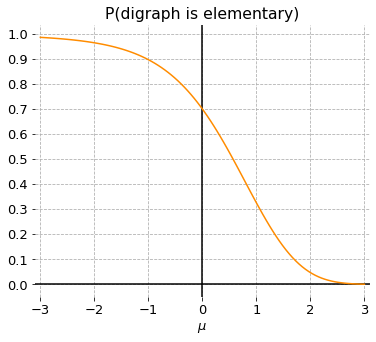

In [647]:
plt.figure(figsize=(6,5))
plt.box(on=False)
plt.xlim(-3.1, 3.1)
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.grid(True, linestyle='--')
plt.xlabel(r"$\mu$")
plt.yticks(np.linspace(0, 1, 11))
plt.plot(
    mu_values_elem,
    p_values_elem,
    color='darkorange')
plt.title('P(digraph is elementary)')
plt.savefig("proba_elem_MDnp.pdf")

# Directed acyclic graphs

The probabilities are given by three simple formulas
$$
    (1 - \lambda), \quad e^\lambda (1 - \lambda), \quad e^{\lambda + \lambda^2/2} (1 - \lambda)
$$

In [648]:
lam_values = np.linspace(0, 1, 100)
MD_values = [1 - lam for lam in lam_values]
D_values = [np.exp(lam + lam**2/2) * (1 - lam) for lam in lam_values]
D2_values = [np.exp(lam) * (1 - lam) for lam in lam_values]

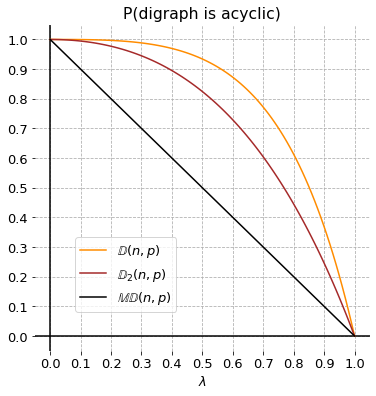

In [659]:
plt.figure(figsize=(6,6))
plt.box(on=False)
#plt.xlim(-3.1, 3.1)
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.grid(True, linestyle='--')
plt.xlabel(r"$\lambda$")
plt.yticks(np.linspace(0, 1, 11))
plt.xticks(np.linspace(0, 1, 11))
plt.plot(lam_values, D_values, color='darkorange', label=r"$\mathbb{D}(n, p)$")
plt.plot(lam_values, D2_values, color='brown', label=r"$\mathbb{D}_2(n, p)$")
plt.plot(lam_values, MD_values, color='black', label=r"$\mathbb{MD}(n, p)$")
plt.title('P(digraph is acyclic)')
plt.legend(loc='best', bbox_to_anchor=(0.1,0.1))
plt.savefig("proba_dag.pdf")

In [676]:
%%time
mu_values_dag = np.linspace(-3, 3, 100)
p_values_dag = [
    (
        2**(-1/3)            # coeff from varphi
        / (2 * np.pi * 1j)   # from Cauchy integral
        *
        complex_quad(
            lambda t:
            1
            / AiryAi(0, -2**(1/3) * t)[0]
            * np.exp(- mu * t - mu**3 / 6)
            ,
            -20j, 20j
        )[0]
    )    
    for mu in mu_values_dag
]

CPU times: user 2min 23s, sys: 788 ms, total: 2min 24s
Wall time: 2min 26s


/usr/local/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


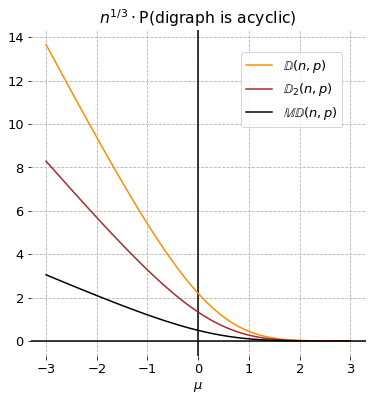

In [678]:
plt.figure(figsize=(6,6))
plt.box(on=False)
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.grid(True, linestyle='--')
plt.xlabel(r"$\mu$")
plt.xticks(np.linspace(-3, 3, 7))
plt.plot(
    mu_values_dag,
    [p * np.exp(1.5) for p in p_values_dag],
    color='darkorange', label=r"$\mathbb{D}(n, p)$")
plt.plot(
    mu_values_dag,
    [p * np.exp(1) for p in p_values_dag],
    color='brown', label=r"$\mathbb{D}_2(n, p)$")
plt.plot(mu_values_dag, p_values_dag, color='black', label=r"$\mathbb{MD}(n, p)$")
plt.title(r"$n^{1/3} \cdot $P(digraph is acyclic)")
plt.legend(loc='best', bbox_to_anchor=(.95,.95))
plt.savefig("proba_dag_critical.pdf")

# Numerical values for I(n,mu)

Take the value of $ a_1' $ from NIST

In [714]:
first_zero_of_ai_prime = -1.0187929716

Check that the first derivative turns to zero.

In [715]:
AiryAi(1, first_zero_of_ai_prime)

((-2.590636000994602e-11-1.6521214595379934e-15j), 1.0718974819373024e-06)

Compare the value of the Airy function with the value given in NIST

In [717]:
AiryAi(0, first_zero_of_ai_prime)[0]

(0.5356566560156996+7.951386703658792e-16j)

Here is an example of a new value not previously present.

In [718]:
AiryAi(-1, first_zero_of_ai_prime)[0]

(-0.8090732962378169-1.236882376124701e-16j)

In [740]:
%%time
def I(k, mu):
    return (
        (-1)**k
        / (2 * np.pi * 1j)   # from Cauchy integral
        *
        complex_quad(
            lambda t:
            AiryAi(-k, -t)[0]
            /
            (AiryAi(1, -t)[0])**2
            * np.exp(- mu * t / 2**(1/3) - mu**3 / 6)
            ,
            -20j, 20j
        )[0]
    )

CPU times: user 12 µs, sys: 140 µs, total: 152 µs
Wall time: 76.1 µs


### Numerical values for the paper

In [746]:
for n in [0,1,2,3,4,5]:
    print("===== n =",n," ======")
    for mu in [-3,-2,-1,0]:
        print("I(",n,",",mu,")= ",I(n,mu))

===== n = 0  ======
I( 0 , -3 )=  (0.7802512697238465-3.9911100880589714e-13j)
I( 0 , -2 )=  (1.0487055827414347-1.7346559223217787e-14j)
I( 0 , -1 )=  (1.4338248188723322-5.625715944159178e-15j)
I( 0 , 0 )=  (1.7117517512707812-4.3536735355067285e-15j)
===== n = 1  ======
I( 1 , -3 )=  (0.29442480002987736-4.3741294325707087e-13j)
I( 1 , -2 )=  (0.5169982248532211-1.7977163554973917e-14j)
I( 1 , -1 )=  (0.936514141016694-5.955292020730727e-15j)
I( 1 , 0 )=  (1.4372766407037851-4.730722269448941e-15j)
===== n = 2  ======
I( 2 , -3 )=  (0.10665460709985743-3.509706949664689e-13j)
I( 2 , -2 )=  (0.2366655203874945-1.4047965410191207e-14j)
I( 2 , -1 )=  (0.5390308295359156-4.6490252262235846e-15j)
I( 2 , 0 )=  (1.000000000000043-3.802736341230832e-15j)
===== n = 3  ======
I( 3 , -3 )=  (0.03729023141427449-2.258342317814226e-13j)
I( 3 , -2 )=  (0.10211304747218718-9.008378206046904e-15j)
I( 3 , -1 )=  (0.28326713657133196-2.9158250103445192e-15j)
I( 3 , 0 )=  (0.6154795912813434-2.4693538

In [747]:
for n in [6,7,8,9,10]:
    print("===== n =",n," ======")
    for mu in [-3,-2,-1,0]:
        print("I(",n,",",mu,")= ",I(n,mu))

===== n = 6  ======
I( 6 , -3 )=  (0.0013372496550247543-5.2021932275992474e-14j)
I( 6 , -2 )=  (0.006269100896502165-2.1982163374528178e-15j)
I( 6 , -1 )=  (0.028195037521574658-6.783855132399428e-16j)
I( 6 , 0 )=  (0.08949352304497135-5.801524651875981e-16j)
===== n = 7  ======
I( 7 , -3 )=  (0.00041965325009517046-2.686785279577211e-14j)
I( 7 , -2 )=  (0.0023028809227066886-1.0820024170613854e-15j)
I( 7 , -1 )=  (0.011891435068910649-3.3347485201043656e-16j)
I( 7 , 0 )=  (0.042035544565868915-2.9956577152050295e-16j)
===== n = 8  ======
I( 8 , -3 )=  (0.0001288980613979984-9.52857234186138e-15j)
I( 8 , -2 )=  (0.0008213859169967622-3.8219493374053007e-16j)
I( 8 , -1 )=  (0.0048315121929001234-1.2739230867439985e-16j)
I( 8 , 0 )=  (0.018904715124359546-1.0288342971746454e-16j)
===== n = 9  ======
I( 9 , -3 )=  (3.8811276859080846e-05-1.6578641221894045e-15j)
I( 9 , -2 )=  (0.00028522869238089437-8.415061000712627e-17j)
I( 9 , -1 )=  (0.001898607005780189-1.767713058222133e-17j)
I( 9 

In [750]:
for n in [0,1,2,3,4,5,6,7,8,9,10]:
    print("Ai(",-n,",a_1')= ",(-1)**n * AiryAi(-n,first_zero_of_ai_prime)[0])

Ai( 0 ,a_1')=  (0.5356566560156996+7.951386703658792e-16j)
Ai( -1 ,a_1')=  (0.8090732962378169+1.236882376124701e-16j)
Ai( -2 ,a_1')=  (0.824278187742238-1.54472252107538e-16j)
Ai( -3 ,a_1')=  (0.6877127401653388-1.9215851200508747e-16j)
Ai( -4 ,a_1')=  (0.5032367341326802-1.1264464496849955e-16j)
Ai( -5 ,a_1')=  (0.3342430588818878-2.5400263081132252e-17j)
Ai( -6 ,a_1')=  (0.2056474438720582+2.3191544552338144e-17j)
Ai( -7 ,a_1')=  (0.11879148409617239-1.2147951908367599e-17j)
Ai( -8 ,a_1')=  (0.06503814113785349-2.457199363283446e-17j)
Ai( -9 ,a_1')=  (0.03398848061865169-1.7462680868278422e-17j)
Ai( -10 ,a_1')=  (0.017046523251757907-5.1076615978363765e-18j)


In [751]:
for n in [0,1,2,3,4,5,6,7,8,9,10]:
    print("===== n =",n," ======")
    for mu in [0,1,2,3,4,5]:
        print("I(",n,",",mu,")= ",I(n,mu))

===== n = 0  ======
I( 0 , 0 )=  (1.7117517512707812-4.3536735355067285e-15j)
I( 0 , 1 )=  (1.1897674561303326-4.01774220411201e-15j)
I( 0 , 2 )=  (0.24107614338825248-1.209298771518301e-15j)
I( 0 , 3 )=  (0.0059367928260589025-4.913488841632104e-17j)
I( 0 , 4 )=  (6.86168240022308e-06-1.1235759004037755e-19j)
I( 0 , 5 )=  (9.277517389342788e-11-3.958002066394771e-24j)
===== n = 1  ======
I( 1 , 0 )=  (1.4372766407037851-4.730722269448941e-15j)
I( 1 , 1 )=  (1.199935952903373-4.1191706880349855e-15j)
I( 1 , 2 )=  (0.2730007028433393-1.3127708544174586e-15j)
I( 1 , 3 )=  (0.007213638526741664-5.211642913024237e-17j)
I( 1 , 4 )=  (8.715677290251674e-06-1.1656965256956016e-19j)
I( 1 , 5 )=  (1.5817064598465756e-10-4.342080187533087e-24j)
===== n = 2  ======
I( 2 , 0 )=  (1.000000000000043-3.802736341230832e-15j)
I( 2 , 1 )=  (0.9517134841394723-3.178665023057445e-15j)
I( 2 , 2 )=  (0.23451589185951988-1.042265459508447e-15j)
I( 2 , 3 )=  (0.006493540904806405-4.1302221847087625e-17j)
I( 2

### Plots of I(n,mu) for the paper

In [827]:
%%time
mu_values_3 = np.linspace(-3, 3, 100)
p_values_3 = [I(3,mu) for mu in mu_values_3]

CPU times: user 5min 29s, sys: 1.48 s, total: 5min 30s
Wall time: 5min 32s


/usr/local/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


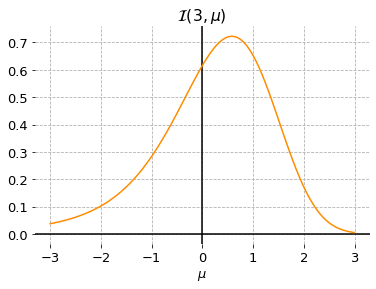

In [830]:
plt.box(on=False)
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.grid(True, linestyle='--')
plt.xlabel(r"$\mu$")
plt.plot(
    mu_values_3,
    p_values_3,
    color='darkorange')
plt.title(r"$\mathcal{I}(3,\mu)$")
plt.savefig("Airy_int_3.pdf")

In [831]:
%%time
mu_values_1 = np.linspace(-3, 3, 100)
p_values_1 = [I(1,mu) for mu in mu_values_1]

CPU times: user 5min 22s, sys: 2.61 s, total: 5min 24s
Wall time: 5min 29s


/usr/local/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


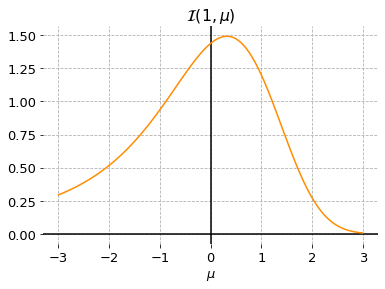

In [832]:
plt.box(on=False)
#plt.xlim(-5, 3.2)
#plt.ylim(-0.01, 0.14)
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.grid(True, linestyle='--')
plt.xlabel(r"$\mu$")
#plt.xticks(np.linspace(-5, 3, 9))
plt.plot(
    mu_values_1,
    p_values_1,
    color='darkorange')
plt.title(r"$\mathcal{I}(1,\mu)$")
#plt.legend(loc='best')
plt.savefig("Airy_int_1.pdf")

In [833]:
%%time
mu_values_4 = np.linspace(-3, 3, 100)
p_values_4 = [I(4,mu) for mu in mu_values_4]

CPU times: user 5min 28s, sys: 2.76 s, total: 5min 31s
Wall time: 5min 36s


/usr/local/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


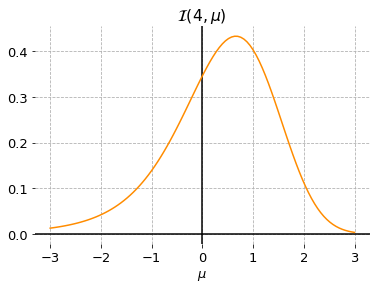

In [834]:
plt.box(on=False)
#plt.xlim(-5, 3.2)
#plt.ylim(-0.01, 0.14)
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.grid(True, linestyle='--')
plt.xlabel(r"$\mu$")
#plt.xticks(np.linspace(-5, 3, 9))
plt.plot(
    mu_values_4,
    p_values_4,
    color='darkorange')
plt.title(r"$\mathcal{I}(4,\mu)$")
#plt.legend(loc='best')
plt.savefig("Airy_int_4.pdf")

In [835]:
%%time
mu_values_5 = np.linspace(-3, 3, 100)
p_values_5 = [I(5,mu) for mu in mu_values_5]

CPU times: user 5min 11s, sys: 1.87 s, total: 5min 13s
Wall time: 5min 16s


/usr/local/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


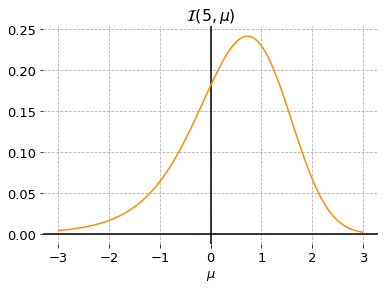

In [836]:
plt.box(on=False)
#plt.xlim(-5, 3.2)
#plt.ylim(-0.01, 0.14)
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.grid(True, linestyle='--')
plt.xlabel(r"$\mu$")
#plt.xticks(np.linspace(-5, 3, 9))
plt.plot(
    mu_values_5,
    p_values_5,
    color='darkorange')
plt.title(r"$\mathcal{I}(5,\mu)$")
#plt.legend(loc='best')
plt.savefig("Airy_int_5.pdf")

### The limiting values for the paper

In [814]:
for mu in [-3,-2,-1,0,1,2,3]:
    print(
        -0.5*
        1 / (2 * np.pi * 1j)   # from Cauchy integral
        *
        complex_quad(
            lambda t:
            1
            /
            AiryAi(1, t)[0]
            * np.exp(2**(-1/3) * mu * t - mu**3 / 6)
            ,
            -20j, 20j
        )[0]
    )

(0.9852124436672949-5.802734589966646e-14j)
(0.9635461266716382-3.3196917249777938e-15j)
(0.8962280858492705-9.374395470989687e-16j)
(0.6996878665105735-6.796289740805662e-16j)
(0.325829461171317-7.803268386015341e-16j)
(0.04740034001935543-1.8126685684671543e-16j)
(0.0008980308325822252-8.69662648247766e-18j)


In [783]:
mu = -2
(
    1 / (2 * np.pi * 1j)   # from Cauchy integral
    *
    complex_quad(
        lambda t:
        AiryAi(-2, t)[0]
        /
        (AiryAi(1, t)[0])**2
        * np.exp(- 2*(-1/3) * mu * t - mu**3 / 6)
        ,
        -30j, 30j
    )[0]
)

(0.5324414968329634-2.1705913610858197e-14j)

In [798]:
mu = 0
(
    2**(1/3) / (2 * np.pi * 1j)   # from Cauchy integral
    *
    complex_quad(
        lambda t:
        -AiryAi(-3, -2**(1/3) * t)[0]
        /
        (AiryAi(1, -2**(1/3) * t)[0])**2
        * np.exp(- mu * t - mu**3 / 6)
        ,
        -20j, 20j
    )[0]
)    

(0.6154795912813313-3.0765966787832915e-15j)

In [804]:
mu = -3
(
    1 / (2 * np.pi * 1j)   # from Cauchy integral
    *
    complex_quad(
        lambda t:
        -AiryAi(-3, t)[0]
        /
        (AiryAi(1, t)[0])**2
        * np.exp(2**(-1/3)*mu * t - mu**3 / 6)
        ,
        -20j, 20j
    )[0]
)    

(0.037290231414279444-2.260616004528652e-13j)

In [817]:
for mu in [0,-3,-2,-1,0,1,2,3]:
    print(
        1/8 *
        1 / (2 * np.pi * 1j)   # from Cauchy integral
        *
        complex_quad(
            lambda t:
            AiryAi(-2,t)[0]
            /
            (AiryAi(1, t)[0])**2
            * np.exp(2**(-1/3) * mu * t - mu**3 / 6)
            ,
            -20j, 20j
        )[0]
    )

(0.12500000000000533-4.753081669679161e-16j)
(0.013331825887482444-4.3869957205926897e-14j)
(0.029583190048436778-1.7562666817737826e-15j)
(0.06737885369198945-5.810372991659993e-16j)
(0.12500000000000533-4.753081669679161e-16j)
(0.11896418551743404-3.974447636716039e-16j)
(0.029314486482439985-1.3028048778103971e-16j)
(0.0008116926131008002-5.160480010296493e-18j)


In [819]:
for mu in [0,-3,-2,-1,0,1,2,3]:
    print(
        2**(-2/3)*
        1 / (2 * np.pi * 1j)   # from Cauchy integral
        *
        complex_quad(
            lambda t:
            1
            /
            (AiryAi(0, t)[0])
            * np.exp(2**(-1/3) * mu * t - mu**3 / 6)
            ,
            -20j, 20j
        )[0]
    )

(0.48873670615299764+6.965145085915183e-17j)
(3.049435206486621+1.6339949976096728e-14j)
(2.0936210688218013-1.5070125509865771e-16j)
(1.2043151541937192+2.522406708388594e-16j)
(0.48873670615299764+6.965145085915183e-17j)
(0.0987622359703129+1.786094370529212e-17j)
(0.005500282535077017+6.074208728630564e-17j)
(3.763216055570679e-05-4.564915218861369e-19j)


In [ ]:
mu = -3
(
    1 / (2 * np.pi * 1j)   # from Cauchy integral
    *
    complex_quad(
        lambda t:
        - AiryAi(-3, t)[0]
        /
        (AiryAi(1, t)[0])**2
        * np.exp(2*(-1/3) * mu * t - mu**3 / 6)
        ,
        -20j, 20j
    )[0]
)

In [824]:
I(3,-3)

(0.03729023141427449-2.258342317814226e-13j)

### Bonus: Plotting different I(n,mu) against one another

Remark that for comparison purposes, we can add an additional scaling factor.
The expression that enters the critical probability is
$$
    2^{d/3 - r} \mathrm{Ai}(1 - 3r + d, \cdot)
$$
so the function $ I(n, \cdot) $ might be additionally rescaled by a factor of $ 2^{n/3} $.

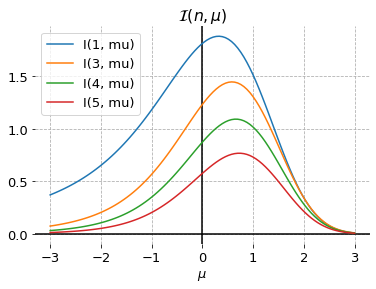

In [852]:
plt.box(on=False)
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.grid(True, linestyle='--')
plt.xlabel(r"$\mu$")
### Now I don't forget the warning that the numbers are complex, and I take the real part
plt.plot(
    mu_values_1,
    [p.real * 2**(1/3) for p in p_values_1],
    label="I(1, mu)")
# The value n = 2 is missing  :( 
# but you can reconstruct it if you want (see below)
plt.plot(
    mu_values_3,
    [p.real * 2**(3/3) for p in p_values_3],
    label="I(3, mu)")
plt.plot(
    mu_values_4,
    [p.real * 2**(4/3) for p in p_values_4],
    label="I(4, mu)")
plt.plot(
    mu_values_5,
    [p.real * 2**(5/3) for p in p_values_5],
    label="I(5, mu)")
plt.title(r"$\mathcal{I}(n,\mu)$")
plt.legend(loc='best')
plt.savefig("Airy_all.pdf")

In [ ]:
%%time
mu_values_2 = np.linspace(-3, 3, 100)
p_values_2 = [I(2,mu) for mu in mu_values_5]

The end.